In [1]:
import pandas as pd
import numpy as np
import re
import nltk

# Import Plotting Libararies
import seaborn as sns
import matplotlib.pyplot as plt

# Import Data Preprocessing Libraries 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.svm import LinearSVC

# Machine Learning Models
from sklearn import svm  

# Model Evaluation Libraries
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
train =  pd.read_csv('C:/Users/EMAAZ/Desktop/Dataset/urdureviews/urdu_reviews_train.csv')
test =   pd.read_csv('C:/Users/EMAAZ/Desktop/Dataset/urdureviews/urdu_reviews_test.csv')
print('Shape of Training Set ' , train.shape,'\nShape of Testing Set ', test.shape)

Shape of Training Set  (40000, 2) 
Shape of Testing Set  (10000, 2)


In [3]:
data =  pd.concat([train, test]).reset_index(drop=True)
print(data.shape)

(50000, 2)


In [4]:
df =  data.copy()

In [5]:
df.head()

,review,sentiment
0,میں نے اسے 80 کی دہائی کے وسط میں ایک کیبل گائ...,positive
1,چونکہ میں نے 80 کی دہائی میں انسپکٹر گیجٹ کارٹ...,negative
2,ایک ایسے معاشرے کی حالت کے بارے میں تعجب کرتا ...,positive
3,مفید البرٹ پیون کی طرف سے ایک اور ردی کی ٹوکری...,negative
4,یہ کولمبو ہے جس کی ہدایتکاری اپنے کیریئر کے اب...,positive


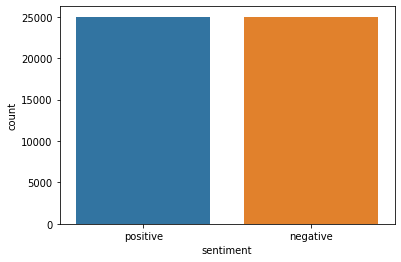

In [6]:
sns.countplot( x = 'sentiment', data = df );

In [7]:
le = LabelEncoder()
le.fit(df['sentiment'])
df['encoded_sentiments'] = le.transform(df['sentiment'])

In [8]:
def removing_unwanted_data(text):
    
    #format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ',text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r"[:؛؟’‘٭ء،۔]+", " ", text)
    text = re.sub(r"[٠‎١‎٢‎٣‎٤‎٥‎٦‎٧‎٨‎٩]+", " ", text)
    text = re.sub(r"[a-zA-z0-9]+", " ", text)
    
    text = nltk.WordPunctTokenizer().tokenize(text)
    
    return text

In [9]:
df['text_cleaned']= list(map(removing_unwanted_data,df.review)) #map -> name and data send in func

In [10]:
df.head()

,review,sentiment,encoded_sentiments,text_cleaned
0,میں نے اسے 80 کی دہائی کے وسط میں ایک کیبل گائ...,positive,1,"[میں, نے, اسے, کی, دہائی, کے, وسط, میں, ایک, ک..."
1,چونکہ میں نے 80 کی دہائی میں انسپکٹر گیجٹ کارٹ...,negative,0,"[چونکہ, میں, نے, کی, دہائی, میں, انسپکٹر, گیجٹ..."
2,ایک ایسے معاشرے کی حالت کے بارے میں تعجب کرتا ...,positive,1,"[ایک, ایسے, معاشرے, کی, حالت, کے, بارے, میں, ت..."
3,مفید البرٹ پیون کی طرف سے ایک اور ردی کی ٹوکری...,negative,0,"[مفید, البرٹ, پیون, کی, طرف, سے, ایک, اور, ردی..."
4,یہ کولمبو ہے جس کی ہدایتکاری اپنے کیریئر کے اب...,positive,1,"[یہ, کولمبو, ہے, جس, کی, ہدایتکاری, اپنے, کیری..."


In [11]:
# Remove stop words from text
from typing import FrozenSet

# Urdu Language Stop words list
STOP_WORDS: FrozenSet[str] = frozenset("""
 آ آئی آئیں آئے آتا آتی آتے آس آمدید آنا آنسہ آنی آنے آپ آگے آہ آہا آیا اب ابھی ابے
 ارے اس اسکا اسکی اسکے اسی اسے اف افوہ البتہ الف ان اندر انکا انکی انکے انہوں انہی انہیں اوئے اور اوپر
 اوہو اپ اپنا اپنوں اپنی اپنے اپنےآپ اکثر اگر اگرچہ اہاہا ایسا ایسی ایسے ایک بائیں بار بارے بالکل باوجود باہر
 بج بجے بخیر بشرطیکہ بعد بعض بغیر بلکہ بن بنا بناؤ بند بڑی بھر بھریں بھی بہت بہتر تاکہ تاہم تب تجھ
 تجھی تجھے ترا تری تلک تم تمام تمہارا تمہاروں تمہاری تمہارے تمہیں تو تک تھا تھی تھیں تھے تیرا تیری تیرے
 جا جاؤ جائیں جائے جاتا جاتی جاتے جانی جانے جب جبکہ جدھر جس جسے جن جناب جنہوں جنہیں جو جہاں جی جیسا
 جیسوں جیسی جیسے حالانکہ حالاں حصہ حضرت خاطر خالی خواہ خوب خود دائیں درمیان دریں دو دوران دوسرا دوسروں دوسری دوں
 دکھائیں دی دیئے دیا دیتا دیتی دیتے دیر دینا دینی دینے دیکھو دیں دیے دے ذریعے رکھا رکھتا رکھتی رکھتے رکھنا رکھنی
 رکھنے رکھو رکھی رکھے رہ رہا رہتا رہتی رہتے رہنا رہنی رہنے رہو رہی رہیں رہے ساتھ سامنے ساڑھے سب سبھی
 سراسر سمیت سوا سوائے سکا سکتا سکتے سہ سہی سی سے شاید شکریہ صاحب صاحبہ صرف ضرور طرح طرف طور علاوہ عین
 فقط فلاں فی قبل قطا لئے لائی لائے لاتا لاتی لاتے لانا لانی لانے لایا لو لوجی لوگوں لگ لگا لگتا
 لگتی لگی لگیں لگے لہذا لی لیا لیتا لیتی لیتے لیکن لیں لیے لے ماسوا مت مجھ مجھی مجھے محترم محترمہ محض
 مرا مرحبا مری مرے مزید مس مسز مسٹر مطابق مل مکرمی مگر مگھر مہربانی میرا میروں میری میرے میں نا نزدیک
 نما نہ نہیں نیز نیچے نے و وار واسطے واقعی والا والوں والی والے واہ وجہ ورنہ وغیرہ ولے وگرنہ وہ وہاں
 وہی وہیں ویسا ویسے ویں پاس پایا پر پس پلیز پون پونی پونے پھر پہ پہلا پہلی پہلے پیر پیچھے چاہئے
 چاہتے چاہیئے چاہے چلا چلو چلیں چلے چناچہ چند چونکہ چکی چکیں چکے ڈالنا ڈالنی ڈالنے ڈالے کئے کا کاش کب کبھی
 کدھر کر کرتا کرتی کرتے کرم کرنا کرنے کرو کریں کرے کس کسی کسے کم کن کنہیں کو کوئی کون کونسا
 کونسے کچھ کہ کہا کہاں کہہ کہی کہیں کہے کی کیا کیسا کیسے کیونکر کیونکہ کیوں کیے کے گئی گئے گا گنا
 گو گویا گی گیا ہائیں ہائے ہاں ہر ہرچند ہرگز ہم ہمارا ہماری ہمارے ہمی ہمیں ہو ہوئی ہوئیں ہوئے ہوا
 ہوبہو ہوتا ہوتی ہوتیں ہوتے ہونا ہونگے ہونی ہونے ہوں ہی ہیلو ہیں ہے یا یات یعنی یک یہ یہاں یہی یہیں
""".split())


def remove_stopwords(text: str):
    return " ".join(word for word in text.split() if word not in STOP_WORDS)

In [12]:
from urduhack.models.lemmatizer import lemmatizer
def lemitizeStr(str):
    lemme_str = ""
    temp = lemmatizer.lemma_lookup(str)
    for t in temp:
        lemme_str += t[0] + " "
    
    return lemme_str

In [13]:
df['review'] =  df['review'].apply(remove_stopwords)

In [14]:
df['lemmatized_text'] = df['review'].apply(lemitizeStr)

In [15]:
df.head()

,review,sentiment,encoded_sentiments,text_cleaned,lemmatized_text
0,80 دہائی وسط کیبل گائیڈ (اسکائینجر ہنٹ پہلو اپ...,positive,1,"[میں, نے, اسے, کی, دہائی, کے, وسط, میں, ایک, ک...",80 دہائی وسط کیبل گائیڈ (اسکائینجر ہنٹ پہلو اپ...
1,80 دہائی انسپکٹر گیجٹ کارٹون پسند ، فلم دیکھنے...,negative,0,"[چونکہ, میں, نے, کی, دہائی, میں, انسپکٹر, گیجٹ...",80 دہائی انسپکٹر گیجٹ کارٹون پسند ، فلم دیکھنے...
2,معاشرے حالت تعجب والد پیدا البرٹ ٹی فٹزجیرالڈ ...,positive,1,"[ایک, ایسے, معاشرے, کی, حالت, کے, بارے, میں, ت...",معاشرے حالت تعجب والد پیدا البرٹ ٹی فٹزجیرالڈ ...
3,مفید البرٹ پیون ردی ٹوکری گریڈ زیڈ جلدی۔ ٹم تھ...,negative,0,"[مفید, البرٹ, پیون, کی, طرف, سے, ایک, اور, ردی...",مفید البرٹ پیون ردی ٹوکری گریڈ زیڈ جلدی۔ ٹم تھ...
4,کولمبو ہدایتکاری کیریئر ابتدائی وقت اسٹیون اسپ...,positive,1,"[یہ, کولمبو, ہے, جس, کی, ہدایتکاری, اپنے, کیری...",کولمبو ہدایتکاری کیریئر ابتدائی وقت اسٹیون اسپ...


In [16]:
print("Samples per class: {}".format(np.bincount(df.encoded_sentiments)))

Samples per class: [25000 25000]


In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(df['lemmatized_text'], df['encoded_sentiments'], test_size = 0.30, random_state = 7)

In [18]:
print('Shape of X_train', X_train.shape)
print('Shape of X_test', X_test.shape)
print('Shape of Y_train', Y_train.shape)
print('Shape of Y_test', Y_test.shape)

Shape of X_train (35000,)
Shape of X_test (15000,)
Shape of Y_train (35000,)
Shape of Y_test (15000,)


In [19]:
import spacy
def tokenizer(str):
    nlp = spacy.blank('ur')
    doc = nlp.tokenizer(str)
    return [i.text for i in doc]
df["tokens"] = df["lemmatized_text"].apply(tokenizer)

In [20]:
import gensim

model_word2vec = gensim.models.Word2Vec(sentences=df["tokens"], size=128, window=5, workers=10, min_count = 1)

In [21]:
model_word2vec.wv.most_similar("مرد")

[('مردوں', 0.7806915640830994),
 ('خواتین', 0.7236655354499817),
 ('عورتوں', 0.7122538089752197),
 ('عورتیں', 0.6766682267189026),
 ('مردانہ', 0.6337434649467468),
 ('سیسہ', 0.6280367374420166),
 ('بوڑھی', 0.6168665885925293),
 ('گورے', 0.5978045463562012),
 ('ننگے', 0.5814326405525208),
 ('ڈیسپ', 0.5664310455322266)]

In [22]:
VOCAB_SIZE = len(model_word2vec.wv.vocab)
DIMENSIONS = 128
MAX_LEN = max([len(x) for x in df["tokens"]])

In [23]:
VOCAB_SIZE, DIMENSIONS, MAX_LEN

(120815, 128, 1769)

In [24]:
from keras.preprocessing.text import Tokenizer
token = Tokenizer()
token.fit_on_texts(df["tokens"])
encoded = token.texts_to_sequences(df["tokens"])

In [25]:
words2vec_matrix = np.zeros((VOCAB_SIZE+1,DIMENSIONS))
for word, index in token.word_index.items():
    try:
        words2vec_matrix[index] = model_word2vec.wv[word]
    except:
        print(index, word)

3374 wwii
3626 dvd
3852 mst3
5288 ps
7903 nyc
8097 3-d
9267 spoilers
9832 wwe
10183 john
10195 csi
10594 french
10667 pow
10721 hal
10791 wwi
10962 sf
11084 d-
11238 kh
11869 asterix
11974 luc
12050 abc
12118 tcm
12157 hg
12512 ufo
12593 bomb
12601 se7en
12735 ww2
12778 dad
12787 nypd
12830 tv
13087 awful
13096 nc-17
13265 q
13439 usa
13985 b-
14131 a&e
14146 ny
14161 bs
14580 vh1
14728 pows
14731 german
14798 cusack
14932 t&a
15192 tos
15339 awol
15341 kiss
15346 hollywood
15524 ww
15655 dj
15773 mst
15796 il
15801 cal
15885 mpaa
16039 lucy
16184 imax
16220 gi
16438 jigsaw
16485 zombie
16543 k-9
16649 chomps
16658 asap
16698 caligula
17011 spoiler
17083 b&w
17090 penelope
17096 lotr
17390 lubitsch
17555 ott
17719 ps2
17899 wwf
17916 cops
18065 ds9
18070 rotj
18113 wb
18134 aa
18703 george
18757 tas
18762 wasp
18959 joe
18963 wip
19018 moe
19053 ps1
19059 i'd
19121 unforgiven
19384 liv
19552 wii
19584 pos
19587 mash
19598 catiii
19680 ikea
19701 soylent
19713 r1
19779 bfg
19940 nwa
200

46104 kiss-
46123 fantastic
46131 z.
46160 mstk3
46169 encrypt
46175 diaboliques
46186 homicide
46242 youtube
46243 ttono
46309 اچھodا
46357 bosn
46417 magnificent
46433 chandler
46474 eater
46477 lazio
46494 10www.residenthazard.com
46513 foabh
46526 hellraiser
46556 alex
46617 diller
46654 hl
46683 dcom
46687 thhe2
46694 ogre
46712 maguire
46775 iمجھے
46803 trail
46832 dawn
46851 cas
46884 scorpion
46892 chorus
46906 tesc
46919 purple
46937 marی
46962 poe
46973 riot
46999 gps
47008 ibiza
47063 damn
47064 tvا
47072 holiday
47087 mass
47108 truman
47141 kon
47167 iran
47199 charmed
47205 awesom
47242 sgt
47262 newman
47310 qe2
47431 impا
47439 versus
47460 xix
47492 yelow
47551 ncis
47552 cosby
47565 doh
47588 cd
47592 cline
47660 comme
47683 rooney
47708 boing
47742 mill
47802 så
47901 lumiere
47924 i`m
47948 kramer
48032 ucm
48052 ymca
48066 ampas
48089 sane
48090 ben
48133 chronicles
48154 jan
48209 hodder
48213 loretta
48220 mahm
48226 snake
48290 schnaas
48328 h6
48359 tho
48425 h

64647 pharoh
64679 gotta
64685 deus.and
64721 wwwaaaayyyyyy
64722 ary
64733 sill
64768 korean
64792 hsps
64813 o-11
64814 australianی
64830 dinner
64838 geslight
64841 maz
64860 picadilly
64861 jim
64862 petticoat
64863 labrador
64883 steer
64889 rod.1
64900 qotsa
64945 noooooo
64996 reign
65007 rogers
65023 c.
65057 snm
65153 reinimator
65156 s01e01
65157 t1000
65160 rnb
65187 proust
65188 recherche
65210 hostage
65242 kish
65243 nishimura
65282 porgy
65284 bess
65286 byw
65287 mdogg20
65288 mdogg
65338 lule
65358 scarecreow
65364 amis
65379 aarrrgh
65394 lol1
65405 fleet
65406 mockney
65408 sms
65490 ucla
65491 s'more
65511 allyson
65569 wsop
65598 caldara
65599 gelato
65602 palی
65626 sétima
65627 vítima
65664 gialli
65712 banditti
65713 plains
65725 douchebag-70369862
65730 choleric
65738 thin1.5
65767 tru
65771 celie
65782 calidor
65793 stubby
65794 kaye
65827 migs
65851 scienceا
65855 satan
65857 creeps
65861 nudity
65862 factorhahaha
65876 rockaroll
65887 earthر
65890 gon
65891 

76637 xن
76661 corey
76697 xp
76719 tewp
76757 k3ol
76794 stereo
76809 johny
76810 test
76813 tiw
76814 watcher
76818 amélie
76825 winter
76826 kills
76838 rawr
76883 scheے
76921 2-dvd
76951 linha
76954 s.شیری
76970 w&g
76972 stairway
76985 looney
76995 beckinsale
77022 fawning
77024 breda
77025 bianco
77050 gack
77078 mamá
77079 también
77117 ventura
77140 تقریباp
77147 jason
77148 fiday
77150 necromaniac
77155 superman
77176 alanis
77178 bioio
77197 torquay
77231 dinocrap
77234 tazer
77244 اوزzی
77247 wraiths
77268 wg
77269 sebald
77274 stmd
77278 accomplice
77289 frits
77362 iiv
77366 texas
77367 chainsa
77402 gd
77403 dm
77455 sel
77465 yank
77467 westpoint
77473 mst3kd
77485 andrienne
77509 sanہ
77533 abe
77548 visitor
77549 necrophilia
77572 clytemnastrae
77573 chill
77574 thrills
77585 inns
77602 prوں
77655 amوں
77700 10bscdb
77703 arی
77732 armitage
77769 hopefully
77770 spawn
77833 sickbottom
77839 knick
77850 cffee
77861 enterrrrrr
77871 amarna
77872 nefer
77882 اوwل
77885 ca

88008 http://us.imdb.com/title؟0093638
88079 rafe
88083 vivian
88085 esme
88093 luana
88094 walters
88114 boogeyman
88115 miz
88144 tou
88145 robert
88146 leonard
88153 http://airwolf.org
88167 m&m
88168 waspy
88172 statesحدہ
88197 dekhne
88198 walon
88199 dewana
88200 yeh
88201 mehndi
88236 2oo4
88237 2oo5
88239 197o
88241 188o
88264 terrrrrrrrrrrrrrriiiiiiiiiiible
88315 weta
88318 chise
88367 nwt
88396 oہ
88404 hms
88424 illiterate
88425 jerks
88426 disneyland
88429 beast
88457 brevity
88458 effectiveness
88459 premature
88460 burial
88469 unifir
88470 prick
88496 kmart
88502 toni
88527 persive
88531 div
88553 horseman
88561 despiteہ
88590 merrill
88617 giss
88623 bettiefile
88625 pinnocioesque
88647 dby
88653 rapture
88665 jesی
88708 beware
88709 dinosaurus
88728 nuf
88736 norman
88766 lololololololololol
88767 dato
88778 longhetti
88816 chooper
88830 sandler
88840 thunderbirds
88912 whiteflokati@hotmail.com
88914 ass.i
88915 fdr
88935 کو't
88944 necroborgs
88976 accent
88984 pad
89

99133 c3
99136 dewey
99146 luhrmann
99149 rating-2
99158 tj
99159 caged
99167 3-dvd
99173 zodiac
99204 flop
99205 sweat
99223 redd
99232 clink
99242 stdvd
99277 moviepicking
99298 premise
99309 bomfunk
99329 vrs
99334 fig
99361 tomei
99365 weismuller
99443 tupelo
99451 usmie
99452 vieers
99461 astonishing
99462 bll
99464 leف
99476 untrue
99501 gunsmoke
99504 wutt
99540 kinky
99564 zhu
99565 quanxin
99573 monon
99581 240z
99670 diabolik
99687 tv14
99691 feر
99721 muی
99732 cwru
99757 nettmare
99758 street.spontaneous
99759 combustion
99764 farscape
99773 nk
99776 niی
99802 un-
99821 logic
99826 nineے
99845 israeliے
99863 lyn
99864 minmay
99867 elr
99872 lwr
99900 ​​dvd
99941 ​​bmoc
99962 wpp
100036 eiff
100050 lil
100054 lieutenant
100077 austen
100081 farce
100085 sorte
100086 nula
100158 ww3
100162 lt
100163 whatن
100165 lexx
100182 laraine
100185 bollywood
100213 indianی
100216 seki
100243 panhandle
100260 ls
100313 chekan
100315 switzerland
100333 diculous
100354 rendition
100384 an

110741 moreau
110753 dauauau
110754 hypothesis
110808 jungle
110833 i-95
110883 grumpy
110884 ald
110896 موouتھ
110923 hon
110925 wayyyy
110938 dvr
110954 16iee
110960 fetes
110970 rpm
110971 broadcast
110985 rw
110995 wb-
111003 fakk
111010 hush
111022 wips
111024 fulci
111047 chistopher
111076 paha
111078 10.garth
111079 marenghi
111117 bravo.a
111122 dads
111127 carا
111157 lyxton
111158 qna
111177 bibbidi
111178 bobbidi
111181 lzy
111185 godi.
111224 lolita
111227 phantasm
111278 puhleez
111332 limit
111384 fargoesque
111394 p.hd
111399 tlk
111401 tlk3
111407 styx
111418 belٹنگ
111419 grant
111451 oiran
111460 saccharine
111465 i&ii
111495 wwii.so
111509 pt.2
111510 s&m
111526 ca$honey
111527 cahoney
111528 jazzy
111529 jeff
111532 gackt
111534 mcbain
111538 cassevetes
111546 hawt
111601 suchet
111603 znyyqhuzzah
111607 taker
111609 10ps
111626 gil
111724 concluson
111733 db5
111743 vulcanoid
111789 merman
111819 funneest
111823 thinnes
111824 brant
111857 verhoeven
111903 vcds
111

In [26]:
import tensorflow as tf
train_vectors = tf.keras.preprocessing.sequence.pad_sequences(encoded,padding='post',dtype=int)

In [27]:
train_label = df.encoded_sentiments

In [28]:
type(train_label[0])

numpy.int32

In [29]:
(train_sentences,test_sentences, train_tags, test_tags) = train_test_split(train_vectors, train_label, test_size=0.2, shuffle = True)

In [30]:
train_sentences

array([[     5, 118686,   1733, ...,      0,      0,      0],
       [     4,   1708,     32, ...,      0,      0,      0],
       [  2579,    148,   2599, ...,      0,      0,      0],
       ...,
       [  1271,   1094,    839, ...,      0,      0,      0],
       [     4,   1851,      3, ...,      0,      0,      0],
       [   215,   2049,     79, ...,      0,      0,      0]])

In [31]:
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
from tensorflow.keras.optimizers import Adam, Optimizer, SGD
import tensorflow.keras.initializers as Init
from tensorflow.keras import regularizers

In [32]:
lstm = Models.Sequential()

lstm.add(Layers.Embedding(VOCAB_SIZE+1,DIMENSIONS,
                          embeddings_initializer = Init.Constant(words2vec_matrix),
                          input_length=MAX_LEN, trainable=False ))

lstm.add(Layers.Bidirectional(Layers.LSTM(256, activation='tanh')))

lstm.add(Layers.Dense(128, activation='tanh'))
lstm.add(Layers.Dropout(0.3))

lstm.add(Layers.Dense(64, activation='tanh'))
lstm.add(Layers.Dropout(0.3))

lstm.add(Layers.Dense(1, activation='sigmoid'))

lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1769, 128)         15464448  
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               788480    
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6

In [33]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
 

lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es_callback = EarlyStopping(monitor='val_loss', patience=3) 
LSTM_NET = lstm.fit(train_sentences, train_tags, epochs=10, validation_split=0.2, callbacks=[es_callback], shuffle=False)

Epoch 1/10
1000/1000 [==============================] - 70074s 70s/step - loss: 0.5852 - accuracy: 0.6876 - val_loss: 0.3766 - val_accuracy: 0.8285
Epoch 2/10
1000/1000 [==============================] - 74916s 75s/step - loss: 0.3677 - accuracy: 0.8425 - val_loss: 0.3420 - val_accuracy: 0.8512
Epoch 3/10
1000/1000 [==============================] - 77875s 78s/step - loss: 0.3227 - accuracy: 0.8669 - val_loss: 0.3380 - val_accuracy: 0.8579
Epoch 4/10
1000/1000 [==============================] - 78469s 78s/step - loss: 0.2891 - accuracy: 0.8803 - val_loss: 0.3392 - val_accuracy: 0.8620
Epoch 5/10
1000/1000 [==============================] - 78860s 79s/step - loss: 0.2534 - accuracy: 0.8984 - val_loss: 0.3667 - val_accuracy: 0.8651
Epoch 6/10
1000/1000 [==============================] - 79453s 79s/step - loss: 0.2123 - accuracy: 0.9213 - val_loss: 0.3996 - val_accuracy: 0.8591


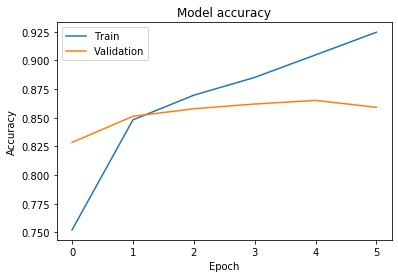

In [34]:
plt.plot(LSTM_NET.history['accuracy'])
plt.plot(LSTM_NET.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

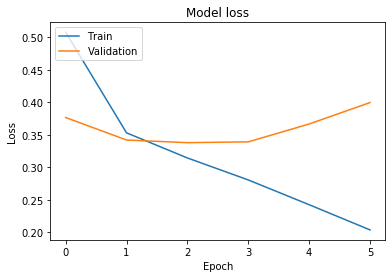

In [35]:
plt.plot(LSTM_NET.history['loss'])
plt.plot(LSTM_NET.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [36]:
print(classification_report(lstm.predict(test_sentences).round(), test_tags))

              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86      4810
         1.0       0.88      0.85      0.87      5190

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

